### Imports et initialisations

In [3]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

### Récupération des tweets

In [4]:
with open("dataset", "r") as file:
    lines = file.readlines()
    
#on travaille avec un échantillon de 5000 tweets
raw_sample = random.sample(lines, 5000)

### Nettoyage

In [5]:
#Fonction de nettoyage rapide (renvoie une liste de mots et plus une chaine de caractères)
def clean(msg):
    #Supprimer les liens
    msg = re.sub(r'https?[^ ]*', ' ', msg)

    #Supprimer hashtags
    msg = re.sub(r'#[^ ]*', ' ', msg)
    #Supprimer tout ce qui n'est pas des lettres
    msg = re.sub(r'\W', ' ', msg)
    #Supprimer les chiffres
    msg = re.sub(r'\d', '', msg)
    #Mettre en minuscule
    msg = msg.lower()
    wlist = msg.split()
    stop_words = set(stopwords.words('french'))
    wlist = [ word for word in wlist if word not in stop_words ]
    return wlist

In [6]:
clean_sample = list(raw_sample)

#Nettoyage des tweets
for i, line in enumerate(raw_sample):
    clean_sample[i] = clean(line)

In [7]:
#On a bien uniquement du texte
print(clean_sample[10])
print(raw_sample[10])

['oh', 'voyagez', 'travers', 'mondes']
⠀⠀ ⠀ ⠀⠀ ‍ ⸻ ❛ Oh ? Vous voyagez à travers les mondes ?



### Récupération des différents mots et de leur nombre d'occurences

Pour l'encodage, nous aurons besoin de connaître la liste des différents mots de notre jeu de données afin d'associer à chacun un nombre.

Pour interpréter les résultats nous aurons besoin de connaître les mots les plus utilisés dans chaque cluster

Pour cela nous utilisons ces fonctions qui permettent d'obtenir une liste des mots du jeu de données (ou d'un sous ensemble comme ce sera le cas avec les clusters) triés par nombre d'occurences décroissant

In [8]:
#Création du dictionnaire de mots avec leur occurence
def create_wdict(lines):
    dico = {}
    for msg in lines:
        for mot in msg:
            if mot in dico: 
                dico[mot] += 1
            else:
                dico[mot] = 1
    return dico

#Création de la liste des mots triée par nombre d'occurences décroissant
def create_sorted_wlist(lines):
    dico = create_wdict(lines)
    wlist = [ (mot, dico[mot]) for mot in dico.keys()]
    return sorted(wlist, key = lambda mot: mot[1], reverse = True)

In [9]:
#dico = create_wdict(sample)

liste_mots_triee = create_sorted_wlist(clean_sample)

print("Il y a {} mots différents".format(len(liste_mots_triee)))
dict_len = len(liste_mots_triee) + 4
print("Les dix mots les plus utilisés sont :")
for mot in liste_mots_triee[1:10]:
    print(mot[0], end=' ')

Il y a 10338 mots différents
Les dix mots les plus utilisés sont :
ça plus si fait tout bien faire quand être 

### Traduction des listes de mots en listes de codes

La première étape de l'encodage est de remplacer les mots par leur code (appelé ici index). 

On crée deux dictionnaires pour l'encodage et le décodage.

In [10]:
word_index_dict = {}
for i, elt in enumerate(liste_mots_triee):
    word_index_dict[elt[0]] = i + 4
    
word_index_dict.update({'<pad>':0, '<start>':1, '<unknown>':2, '<undef>':3,})

index_word_dict = { i:word for word,i in word_index_dict.items() }

In [11]:
def encode(msg):
    encoded_msg = [1]
    for mot in msg:
        try:
            encoded_msg.append(word_index_dict[mot])
        except KeyError:
            encoded_msg.append(2)
    return encoded_msg
        
def decode(msg):
    #decoded_msg = ""
    #for elt in msg:
    #    decoded_msg += index_word_dict[elt] + " "
    #return decoded_msg
    return ' '.join([index_word_dict[i] for i in msg])

msg = "Coucou les petits loulous."
#msg = ["coucou", "les", "petits", "loulous"]
enc = encode(clean(msg))
print(enc)
print(decode(enc))

[1, 1026, 788, 2]
<start> coucou petits <unknown>


In [12]:
#encodage de l'échantillon pour créer le jeu de données
dataset = [encode(msg) for msg in clean_sample]

In [13]:
print(dataset[10])
decode(dataset[10])

[1, 177, 3909, 2390, 3910]


'<start> oh voyagez travers mondes'

### Encodage one-hot proprement dit

Chaque message est transformé en un vecteur de la taille du dictionnaire. Pour chaque mot dans un message, l'indice du vecteur correspondant à ce message est mis à 1, le reste des indices reste à 0.

In [14]:
def one_hot_encode(dataset, vector_size=dict_len):
    dataset_encoded = np.zeros((len(dataset), vector_size))
    for i, msg in enumerate(dataset):
        for code in msg:
            dataset_encoded[i, code] = 1
    return dataset_encoded
    

In [15]:
#encodage du dataset

dataset_encoded = one_hot_encode(dataset)

### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode Truncated SVD qui est indiquée dans le cas de données éparses

In [19]:
%%time

#Prend une quarantaine de seconds à exécuter sur ma machine

svd = TruncatedSVD()

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = svd.fit_transform(dataset_encoded)

CPU times: user 14.8 s, sys: 5.01 s, total: 19.8 s
Wall time: 12.3 s


In [20]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)

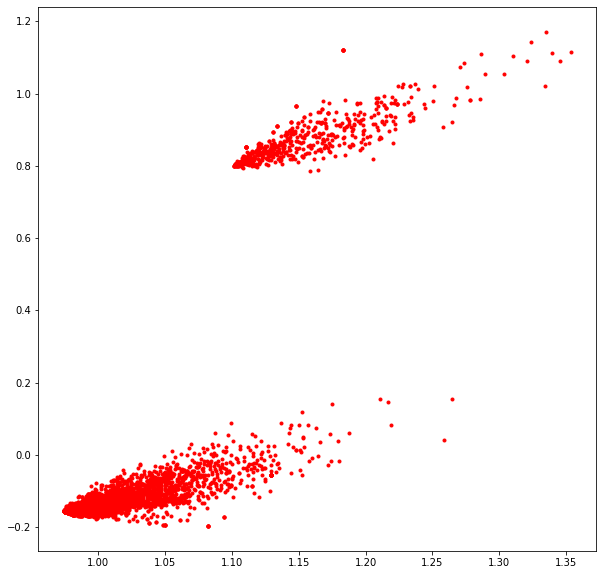

In [21]:
#Affichage des données
plt.plot(b[0], b[1], 'r.')
plt.show()

### Fonctions pour la visualisation des clusters

Les algorithmes de classification renvoient une liste de la taille de notre dataset. Chaque élément de cette liste correspond au numéro de cluster auquel le message du même indice de notre jeu de données est associé.

Pour interpréter les résultats on a besoin de connaître les messages de chaque clusters on définit donc quelques fonctions qui vont nous permettre de manipuler les données :

- Une fonction qui construit un dictionnaire qui a chaque cluster associe la liste des indices des messages correspondants
- Une fonction qui construit la liste des mots et la liste des messages de chaque cluster.
- Une fonction qui affiche le nombre de messages pour chaque cluster
- Une fonction qui affiche pour chaque cluster la liste des n mots les plus utilisés
- Une fonction qui affiche un échantillon de messages pour chaque cluster
- Une fonction qui permet de visualiser les données catégorisées
- Et une fonction qui fait tout ça à la fois !

In [36]:
#Construire le dictionnaire des résultats qui à chaque cluster associe la liste indices des messages correspondants

def build_res_dict(pred):
    res = {}
    for i, lab in enumerate(pred): 
        if lab in res:
            res[lab].append(i)
        else:
            res[lab] = [i]
    return res
    
#construire la liste des mots et la liste des messages de chaque cluster
#utilise les variables globales clean_sample et raw_sample
def create_word_and_msg_lists(res):
    wlists = []
    mlists = []
    for i in res.keys():
        idx_list = []
        msg_list = []
        raw_msg_list = []
        for n in res[i]: idx_list.append(n)
        for idx in idx_list: 
            msg_list.append(clean_sample[idx])
            raw_msg_list.append(raw_sample[idx])
        mlists.append(raw_msg_list)
        wlists.append(create_sorted_wlist(msg_list))
    return wlists, mlists

def print_clusters_size(res):
    for i, key in enumerate(res.keys()):
        print("cluster {} : {} messages".format(i, len(res[key])))

def print_most_used_words(n, wlists):
    for i, liste in enumerate(wlists):
        print("Les {} mots les plus fréquents du cluster {} :".format(n, i), end=" ")
        for tup in liste[:n]:
            print(tup[0], end=' ')
        print('\n')
        
def print_sample(sample_size, res):
    for i, key in enumerate(res.keys()):
        print("cluster {} (clé {})".format(i, key))
        try:
            sample = random.sample(res[key], sample_size)
        except ValueError:
            sample = res[key]
        for j in sample:
            print(raw_sample[j])
        print()

def plot_results(res):
    styles = ["r.", "b.", "k.", "g.", "y.", "c.", "m."]
    i = 0
    j = 0
    for key in res.keys():
        cluster_data = []
        for idx in res[key]:
            cluster_data.append(two_dim_dataset[idx])
        tcd = np.array(cluster_data).T
        if (j > 6): j = 0
        plt.plot(tcd[0], tcd[1], styles[j])
        i += 1
        j += 1
    plt.show()
    
def save_clusters_msg(mlists, method):
    if not os.path.exists("one_hot_clusters/{}".format(method)): 
        os.mkdir("one_hot_clusters/{}".format(method))
    for i, mlist in enumerate(mlists):
        with open("one_hot_clusters/{0}/{0}_cluster_{1}_msg.txt".format(method, i), "w") as f:
            for msg in mlist:
                f.write(msg)
                
def parse_results(pred, method):
    res = build_res_dict(pred)
    wlists, mlists = create_word_and_msg_lists(res)
    print_clusters_size(res)
    print_most_used_words(20, wlists)
    print_sample(3, res)
    plot_results(res)
    save_clusters_msg(mlists, method)
    

### Kmeans

In [23]:
n_clust = 4

In [24]:
%%time

kmeans = KMeans(n_clusters=n_clust, random_state=0).fit(dataset_encoded)

CPU times: user 24.8 s, sys: 75.4 ms, total: 24.8 s
Wall time: 10.3 s


In [25]:
km_pred = kmeans.predict(dataset_encoded)

In [26]:
km_res = build_res_dict(km_pred)

#nombre de tweets par catégories
print_clusters_size(km_res)

cluster 0 : 4181 messages
cluster 1 : 292 messages
cluster 2 : 525 messages
cluster 3 : 2 messages


In [28]:
km_wlists, km_mlists = create_word_and_msg_lists(km_res)
print_most_used_words(10, km_wlists)

Les 10 mots les plus fréquents du cluster 0 : plus si bien tout quand faire être fait trop non 

Les 10 mots les plus fréquents du cluster 1 : ça a fait va comme non bien plus être faire 

Les 10 mots les plus fréquents du cluster 2 : a fait tout faire ans plus quand si rien cette 

Les 10 mots les plus fréquents du cluster 3 : quintuplé minutes jean chales sabattier robert lewandowski vidéo trop parfaite 



In [29]:
print_sample(5, km_res)

cluster 0 (clé 3)
Meilleur chauffage https://t.co/UkgLnu7Q9J

"Surcoût de 1

Pas eu de bugs sinon je l'aurais évoqué ^^

"Partagé RT en masse pour retrouvé mon chat TOM volé depuis 3 ans

C'est que des homosexuels dans les commentaires


cluster 1 (clé 1)
"Bonsoir je sais pas qui est le mako de ma soeur qui a été lui dire que je fais ci ou ça sur internet mais : Véyé tchou a manmanw.Cordialement

Mdrr il porte du Tommy jsuis en repos ça me suis jusque sur Netflix

Haaaa Sisi dans le 94 comme ça la 😭😭

🤣🤣🤣Oui elles sont top 🥰Je le ai vues sur quelqu'un que je peux pas blairer ça m'a soulée 😒

"Je parle avec un pote à moi dans son quartier ça devait mettre la fibre


cluster 2 (clé 2)
et qui a tiré ce jeune?

Y’a des gens qui se clashent encore sur Twitter? 🥴

Belle victoire de et félicitations à l'homme qui a tout donné pour gagner cette élection Il a déjà averti : l'indépendance de est sacrée et il veillera à ce qu'aucune interférences du pouvoir ne viennent perturber les travaux de l'

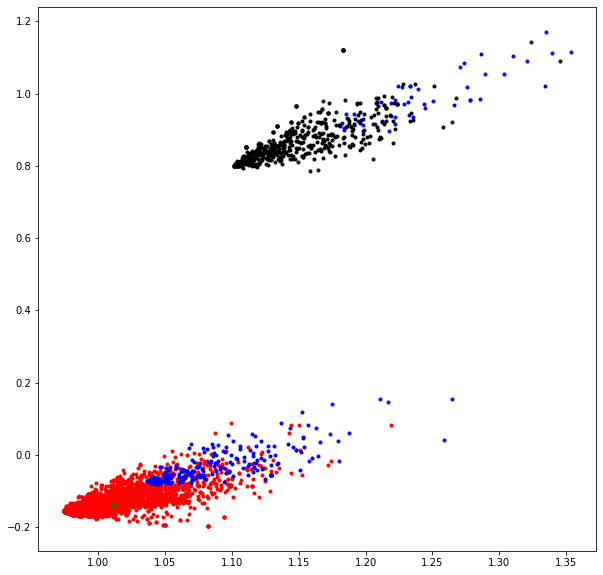

In [30]:
plot_results(km_res)

In [37]:
save_clusters_msg(km_mlists, "km")

### SOM

In [133]:
from sklearn_som.som import SOM

In [134]:
%%time

som = SOM(m=5, n=5, dim=dict_len)
som.fit(dataset_encoded)

CPU times: user 42.9 s, sys: 673 ms, total: 43.5 s
Wall time: 43.6 s


In [135]:
%%time

som_pred = som.predict(dataset_encoded)

CPU times: user 5.18 s, sys: 0 ns, total: 5.18 s
Wall time: 5.18 s


cluster 0 : 142 messages
cluster 1 : 376 messages
cluster 2 : 75 messages
cluster 3 : 153 messages
cluster 4 : 88 messages
cluster 5 : 1755 messages
cluster 6 : 160 messages
cluster 7 : 442 messages
cluster 8 : 251 messages
cluster 9 : 241 messages
cluster 10 : 170 messages
cluster 11 : 155 messages
cluster 12 : 58 messages
cluster 13 : 109 messages
cluster 14 : 85 messages
cluster 15 : 104 messages
cluster 16 : 154 messages
cluster 17 : 62 messages
cluster 18 : 25 messages
cluster 19 : 219 messages
cluster 20 : 34 messages
cluster 21 : 95 messages
cluster 22 : 28 messages
cluster 23 : 16 messages
cluster 24 : 3 messages
Les 20 mots les plus fréquents du cluster 0 : surprise dm manifesting quel cette cutie veux amp personne équipe sous voir aller annonce allez projet femme répondre vraiment demais 

Les 20 mots les plus fréquents du cluster 1 : a plus ans molina quand ça fait dit être cette rien voir jamais quelqu vie jour juste tous fin si 

Les 20 mots les plus fréquents du cluster 2

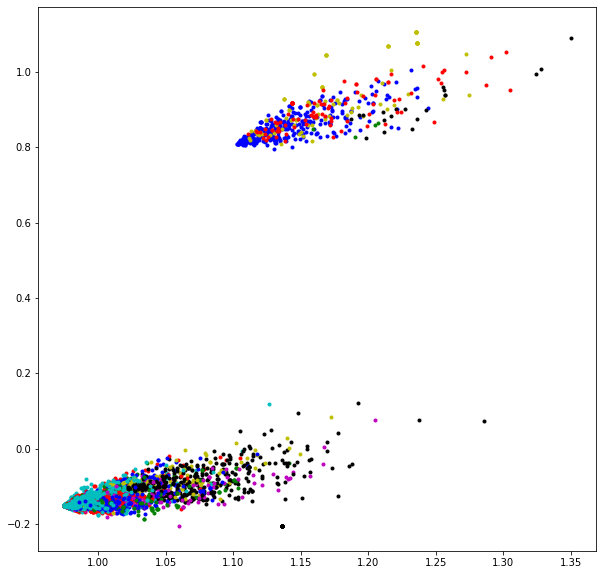

In [140]:
parse_results(som_pred, "som")

### DBSCAN

In [146]:
from sklearn.cluster import DBSCAN

In [150]:
%%time

dbscan_pred = DBSCAN().fit_predict(dataset_encoded)

CPU times: user 3min 12s, sys: 17.9 ms, total: 3min 12s
Wall time: 3min 12s


cluster 0 : 4810 messages
cluster 1 : 7 messages
cluster 2 : 5 messages
cluster 3 : 8 messages
cluster 4 : 6 messages
cluster 5 : 6 messages
cluster 6 : 5 messages
cluster 7 : 5 messages
cluster 8 : 35 messages
cluster 9 : 7 messages
cluster 10 : 9 messages
cluster 11 : 6 messages
cluster 12 : 5 messages
cluster 13 : 18 messages
cluster 14 : 5 messages
cluster 15 : 5 messages
cluster 16 : 6 messages
cluster 17 : 6 messages
cluster 18 : 5 messages
cluster 19 : 5 messages
cluster 20 : 5 messages
cluster 21 : 6 messages
cluster 22 : 7 messages
cluster 23 : 10 messages
cluster 24 : 8 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand fait faire tout cette être comme bien va trop tous quoi non là rt rien 

Les 20 mots les plus fréquents du cluster 1 : oui 

Les 20 mots les plus fréquents du cluster 2 : voilà 

Les 20 mots les plus fréquents du cluster 3 : merci 

Les 20 mots les plus fréquents du cluster 4 : yassification 

Les 20 mots les plus fréquents du cluster 5 

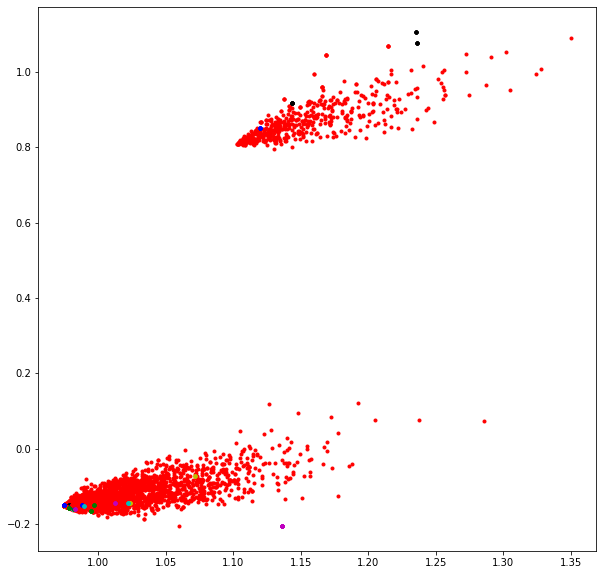

In [151]:
parse_results(dbscan_pred, "dbscan")

In [155]:
from sklearn.metrics import pairwise_distances

a = dataset_encoded[0]
b = dataset_encoded[1]

pairwise_distances(dataset_encoded)

array([[0.        , 5.38516481, 3.46410162, ..., 4.79583152, 3.87298335,
        3.60555128],
       [5.38516481, 0.        , 5.56776436, ..., 6.4807407 , 6.        ,
        5.83095189],
       [3.46410162, 5.56776436, 0.        , ..., 5.        , 4.35889894,
        4.12310563],
       ...,
       [4.79583152, 6.4807407 , 5.        , ..., 0.        , 5.47722558,
        5.29150262],
       [3.87298335, 6.        , 4.35889894, ..., 5.47722558, 0.        ,
        4.47213595],
       [3.60555128, 5.83095189, 4.12310563, ..., 5.29150262, 4.47213595,
        0.        ]])

### Affinity propagation

In [156]:
from sklearn.cluster import AffinityPropagation

In [157]:
%%time

AP_pred = AffinityPropagation().fit_predict(dataset_encoded)

CPU times: user 5min 8s, sys: 987 ms, total: 5min 9s
Wall time: 5min 9s


/home/victor/fidle/fidle-env/lib/python3.9/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


cluster 0 : 5000 messages
Les 20 mots les plus fréquents du cluster 0 : a ça plus si quand tout faire fait cette être comme bien va trop non tous quoi merci rt là 

cluster 0 (clé -1)
M. Pokora si les actes ne l’avait pas manqués https://t.co/Q7U9upiEjc

Le programme des équipes du CBB jouant à domicile samedi prochain #cherbourgbasketball #cherbourg #basket #CBB #championnat #matchs #region https://t.co/44W849jlGG

C'est une de nos qualités quand on est Army😌😌 tmtc




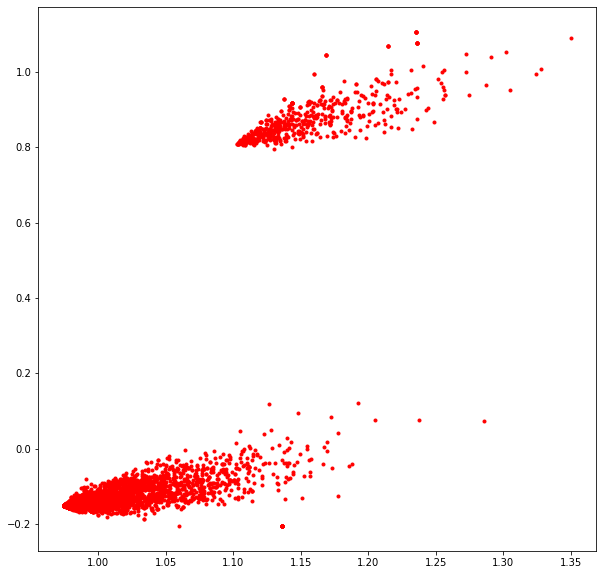

In [159]:
parse_results(AP_pred, "AP")